In [1]:
!pip install wandb -qqq
!pip install pyDOE
!pip install SobolSequence

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=6b1c04e3b43cc1d48241e79ff8530c7836fd7039f8e597dd88d09fd25d833271
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [2]:

import time
import wandb
import pickle
import numpy as np
import tensorflow as tf
from math import pi, exp
from scipy.stats import norm
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow import GradientTape as G_Tape
from tensorflow.keras.layers import Input, Dense, Reshape
from tensorflow.keras.optimizers.legacy import Adam, RMSprop
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.metrics import mean_squared_error

n_dim = 1

#Define global variables
r = 0.06
T = 1
K = 40
sigma = 0.20
DTYPE = 'float32'

#Fix seeds
random_seed = 2
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [3]:

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
class Sampler_IBC():
    def __init__(self, lb, ub, cond=None, N_points=100,
                 method='uniform', grid=None, split=False, DTYPE='float64'):
        self.lb = lb
        self.ub = ub
        self.cond = cond
        self.DTYPE = DTYPE
        self.sample(N_points, method, grid, split)

    def sample(self, N_points, method, grid, split):
        if method == 'uniform':
            x_ibc = np.random.uniform(0, 1, size=(N_points, self.ub.shape[0]))
            x_ibc = self.lb + (self.ub - self.lb)*x_ibc
        elif method == 'latin':
            from pyDOE import lhs
            x_ibc = self.lb + (self.ub - self.lb)*lhs(self.ub.shape[0],N_points)
        elif method == 'sobol':
            import sobol
            x_ibc = sobol.sample(dimension=self.ub.shape[0], n_points=N_points)
            x_ibc = self.lb + (self.ub - self.lb)*x_ibc
        elif method == 'equi':
            x_ibc = np.linspace(self.lb, self.ub, N_points)
        elif method == 'grid':
            x_ibc = np.linspace(self.lb, self.ub, N_points).T
            temp_final = list()
            for val in x_ibc[0]:
                temp_final.append( [val] )
            dim = 1
            while dim < x_ibc.shape[0]:
                temp = list()
                for t1 in range(x_ibc.shape[1]):
                    for t2 in range(len(temp_final)):
                        temp_val = temp_final[t2].copy()
                        temp_val.append( x_ibc[dim, t1] )
                        temp.append( temp_val )
                temp_final = temp
                dim += 1
            x_ibc = np.array(temp_final)
        elif method == 'grid_old':
            idx = np.random.choice(range(grid.shape[0]),N_points,replace=False)
            x_ibc = grid[idx]
        if self.cond != None:
            y_ibc = self.cond(x_ibc)
            self.y = tf.cast(tf.Variable(y_ibc, trainable=False ),
                             self.DTYPE)
        if split:
            x_ibc, t_ibc = x_ibc[:, :-1], x_ibc[:, -1:]
            self.t = tf.cast(tf.Variable(t_ibc, trainable=False ),
                             self.DTYPE)
        self.x = tf.cast(tf.Variable(x_ibc, trainable=False ),
                         self.DTYPE)

In [5]:
#Define domain boundaries
lb = np.array([0., 0.])
ub = np.array([3.*K, T])

#Define conditions
def h_1(inp):
    res = list()
    for inp_val in inp:
        res.append( K - inp_val[0] )
    return np.array(res)

def h_2(inp):
    res = - np.ones( inp.shape[0] )
    return res

def g(inp):
    res = np.zeros( inp.shape[0] )
    return np.array(res)

def u_0(inp):
    res = list()
    for inp_val in inp:
        x, t = inp_val
        res.append( np.max([0, K-x]) )
    return np.array(res)

def s_0(inp):
    res = np.ones( inp.shape[0] ) * K
    return np.array(res)

#Point sampling
N_to_sample = 300

#---------------- PDE Conditions
print('PDE COnditions\n')
#Initial
init_sampler = Sampler_IBC(np.array([0., T]),
                           np.array([3.*K, T]),
                           u_0, N_to_sample, DTYPE=DTYPE, method='sobol' )
print( f'x: {init_sampler.x.shape}     y: {init_sampler.y.shape}' )

#Dirichlet
dir_sampler = Sampler_IBC(np.array([3.*K, 0.]), np.array([3.*K, T]),
                          g, N_to_sample, DTYPE=DTYPE, method='sobol' )
print( f'x: {dir_sampler.x.shape}     y: {dir_sampler.y.shape}' )

#Neumann
print('No')

#---------------- Free Boundary Conditions
print('\nFree Boundary COnditions\n')
#Initial
init_fb_sampler = Sampler_IBC(np.array([T]), np.array([T]),
                              s_0, 1, DTYPE=DTYPE )
print( f't: {init_fb_sampler.x.shape}     y: {init_fb_sampler.y.shape}' )

#Dirichlet
dir_fb_sampler = Sampler_IBC(np.array([0.]), np.array([T]),
                             None, N_to_sample, DTYPE=DTYPE, method='sobol' )
print( f't: {dir_fb_sampler.x.shape}' )

#Neumann
neu_fb_sampler = Sampler_IBC(np.array([0.]), np.array([T]),
                             h_2, N_to_sample, DTYPE=DTYPE, method='sobol' )
print( f't: {neu_fb_sampler.x.shape}     y: {neu_fb_sampler.y.shape}' )

#---------------- Conditions passed to PINN
pinn_conditions = {'Initial':init_sampler,
                   'Dirichlet':dir_sampler,
                   'Neumann':None}
fb_conditions = {'Initial':init_fb_sampler,
                 'Dirichlet':dir_fb_sampler,
                 'Neumann':neu_fb_sampler}


PDE COnditions

x: (300, 2)     y: (300,)
x: (300, 2)     y: (300,)
No

Free Boundary COnditions

t: (1, 1)     y: (1,)
t: (300, 1)
t: (300, 1)     y: (300,)


In [6]:
test_sampler = Sampler_IBC(lb, ub, cond=None, DTYPE=DTYPE,
                           N_points=1000000, method='uniform', split=True)

#Point sampling
sample_to_test = 1000

#---------------- PDE Conditions
print('PDE COnditions\n')
#Initial
init_sampler_test = Sampler_IBC(np.array([0., T]),
                           np.array([3.*K, T]),
                           u_0, sample_to_test, DTYPE=DTYPE, method='uniform' )
print( f'x: {init_sampler_test.x.shape}     y: {init_sampler_test.y.shape}' )

#Dirichlet
dir_sampler_test = Sampler_IBC(np.array([3.*K, 0.]), np.array([3.*K, T]),
                          g, sample_to_test, DTYPE=DTYPE, method='uniform' )
print( f'x: {dir_sampler_test.x.shape}     y: {dir_sampler_test.y.shape}' )

#Neumann
print('No')

#---------------- Free Boundary Conditions
print('\nFree Boundary COnditions\n')
#Initial
init_fb_sampler_test = Sampler_IBC(np.array([T]), np.array([T]),
                              s_0, 1, DTYPE=DTYPE, method='uniform' )
print( f't: {init_fb_sampler_test.x.shape}     y: {init_fb_sampler_test.y.shape}' )

#Dirichlet
dir_fb_sampler_test = Sampler_IBC(np.array([0.]), np.array([T]),
                             None, sample_to_test, DTYPE=DTYPE, method='uniform' )
print( f't: {dir_fb_sampler_test.x.shape}' )

#Neumann
neu_fb_sampler_test = Sampler_IBC(np.array([0.]), np.array([T]),
                             h_2, sample_to_test, DTYPE=DTYPE, method='uniform' )
print( f't: {neu_fb_sampler_test.x.shape}     y: {neu_fb_sampler_test.y.shape}' )

#---------------- Conditions passed to PINN
pinn_cond_test = {'Initial':init_sampler_test,
                   'Dirichlet':dir_sampler_test,
                   'Neumann':None}
fb_cond_test = {'Initial':init_fb_sampler_test,
                 'Dirichlet':dir_fb_sampler_test,
                 'Neumann':neu_fb_sampler_test}

PDE COnditions

x: (1000, 2)     y: (1000,)
x: (1000, 2)     y: (1000,)
No

Free Boundary COnditions

t: (1, 1)     y: (1,)
t: (1000, 1)
t: (1000, 1)     y: (1000,)


In [7]:
#Define PDE
def pde(tape, xs, ts, u_val, u_x):
    u_xx = tape.gradient(u_x, xs)
    u_t = tape.gradient(u_val, ts)
    del(tape)
    u_val = tf.cast(u_val, DTYPE)
    f = (r * xs * u_x) + u_t + (sigma**2 * xs**2 * u_xx)/2 - (r * u_val)
    return f

In [8]:
class FreeBoundary_PINN():

    def __init__(self, params, pde, ibc_cond, ibc_fb_cond, lb, ub,
                 N_f=10000, N_fb_ibc=150, DTYPE='float64', coll_points=None):
        self.params = params
        self.DTYPE = DTYPE
        self.Default_Params()
        #Set seed
        if self.params['seed'] != None:
            tf.keras.utils.set_random_seed( self.params['seed'] )
            tf.config.experimental.enable_op_determinism()
        #Define pde
        self.pde = pde
        #Define intial and boundary conditions
        self.ibc_cond = ibc_cond
        self.ibc_fb_cond = ibc_fb_cond
        #All needed for points sampling
        self.lb = tf.Variable(lb, trainable=False)
        self.ub = tf.Variable(ub, trainable=False)
        if coll_points == None:
            self.N_f = N_f
            self.Sample_Points()
        else:
            self.x_f = coll_points[0]
            self.t_f = coll_points[1]
        self.N_fb_ibc = N_fb_ibc
        #Initialize the class: define the network
        self.Define_Regularizer()
        self.Define_Initializer()
        self.Define_Optimizer()
        self.Create_Network()
        self.Create_FB_Network()

    def Default_Params(self):
        target = self.params.keys()
        if 'seed' not in target:
            self.params['seed'] = None
        if 'optimizer' not in target:
            self.params['optimizer'] = 'Adam'
        if 'reg_type' not in target:
            self.params['reg_type'] = None
        if 'initializer' not in target:
            self.params['initializer'] = 'glorot_normal'
        if 'activation' not in target:
            self.params['activation'] = 'tanh'
        if 'output_act' not in target:
            self.params['output_act'] = 'linear'
        if 'pde_weight' not in target:
            self.params['pde_weight'] = 1.
        if 'sup_weight' not in target:
            self.params['sup_weight'] = [1., 1., 1.]
        if 'fb_weight' not in target:
            self.params['fb_weight'] = [1., 1., 1.]
        if 'patience' not in target:
            self.params['patience'] = np.inf
        if 'sample_method' not in target:
            self.params['sample_method'] = 'uniform'
        if 'fb_output_act' not in target:
            self.params['fb_output_act'] = 'linear'
        if 'fb_activation' not in target:
            self.params['fb_activation'] = 'tanh'
        if 'verbose' not in target:
            self.params['verbose'] = 1
        if 'steps_fb_per_pde' not in target:
            self.params['steps_fb_per_pde'] = 1
        if 'fb_freezing' not in target:
            self.params['fb_freezing'] = None

    def Define_Regularizer(self):
        if self.params['reg_type'] == 'l1':
            self.regularizer = l1( self.params['reg'] )
        elif self.params['reg_type'] == 'l2':
            self.regularizer = l2( self.params['reg'] )
        elif self.params['reg_type'] == 'l1_l2':
            self.regularizer = l1_l2( self.params['reg'][0],
                                      self.params['reg'][1] )
        else:
            self.regularizer = None

    def Define_Initializer(self):
        if self.params['initializer'] == 'glorot_normal':
            self.initializer = GlorotNormal()
        elif self.params['initializer'] == 'glorot_uniform':
            self.initializer = GlorotUniform()
        else:
            self.initializer = None

    def Define_Optimizer(self):
        temp = self.params['optimizer']
        if temp.lower() == 'adam':
            self.opt = Adam( self.params['lr'] )
        elif temp.lower() == 'rmsprop':
            self.opt = RMSprop( self.params['lr'] )
        else:
            raise ValueError(f"Optimizer {temp} not recognized")

    def Create_Network(self):
        input_layer = Input(shape=self.params['layers'][0],
                            name = 'Input')
        x = Dense(units=self.params['layers'][1],
                  activation=self.params['activation'],
                  kernel_initializer=self.initializer,
                  kernel_regularizer=self.regularizer,
                  name='Dense_1')(input_layer)
        for layer in range(2, len(self.params['layers'])-1):
            x = Dense(units=self.params['layers'][layer],
                      activation=self.params['activation'],
                      kernel_initializer=self.initializer,
                      kernel_regularizer=self.regularizer,
                      name=f'Dense_{layer}')(x)
        output = Dense(units=self.params['layers'][-1],
                       activation=self.params['output_act'],
                       kernel_initializer=self.initializer,
                       kernel_regularizer=self.regularizer,
                       name='Output')(x)
        self.mdl = Model(inputs=input_layer, outputs=output)

    def Create_FB_Network(self):
        input_layer = Input(shape=self.params['fb_layers'][0],
                            name = 'Input')
        x = Dense(units=self.params['fb_layers'][1],
                  activation=self.params['fb_activation'],
                  kernel_initializer=self.initializer,
                  kernel_regularizer=self.regularizer,
                  name='Dense_1')(input_layer)
        for layer in range(2, len(self.params['fb_layers'])-1):
            x = Dense(units=self.params['fb_layers'][layer],
                      activation=self.params['fb_activation'],
                      kernel_initializer=self.initializer,
                      kernel_regularizer=self.regularizer,
                      name=f'Dense_{layer}')(x)
        output = Dense(units=self.params['fb_layers'][-1],
                       activation=self.params['fb_output_act'],
                       kernel_initializer=self.initializer,
                       kernel_regularizer=self.regularizer,
                       name='Output')(x)
        self.fb = Model(inputs=input_layer, outputs=output)

    def Sample_Points(self):
        #According to the selected method, sample collocation points
        method = self.params['sample_method']
        if method == 'latin':
            from pyDOE import lhs
            cps = self.lb + (self.ub - self.lb)*lhs(self.ub.shape[0], self.N_f)
        elif method == 'uniform':
            cps = np.random.uniform(0, 1, size=(self.N_f, self.ub.shape[0]))
            cps = self.lb + (self.ub - self.lb)*cps
        elif method == 'sobol':
            import sobol
            cps = sobol.sample(dimension=self.ub.shape[0], n_points=self.N_f)
            cps = self.lb + (self.ub - self.lb)*cps
        else:
            raise ValueError(f'Sampling method {method} not recognized')
        #Return collocation points as tf tensors
        self.x_f_total = tf.cast(tf.Variable(cps[:, :-1], trainable=False),
                                 self.DTYPE)
        self.t_f_total = tf.cast(tf.Variable(cps[:, -1:], trainable=False),
                                 self.DTYPE)

    @tf.function
    def train_step(self):
        with G_Tape(watch_accessed_variables=False) as mdl_tape:
            #Watch solution weights
            mdl_tape.watch(self.mdl.trainable_variables)
            #--------------- Compute Free Boundary losses
            with G_Tape(watch_accessed_variables=False) as fb_tape:
                #Watch free boundary weights
                fb_tape.watch(self.fb.trainable_variables)
                #Compute Initial Free Boundary Condition
                fb_init = self.fb(self.ibc_fb_cond['Initial'].x,
                                      training=True)
                fb_init_loss = tf.math.reduce_mean(
                    tf.math.square(fb_init-self.ibc_fb_cond['Initial'].y)
                    )
                #Compute Dirichlet Free Boundary Condition
                if self.ibc_fb_cond['Dirichlet'] != None:
                    #Compute Free Boundary values
                    s_values = self.fb(self.ibc_fb_cond['Dirichlet'].x,
                                       training=True)
                    fb_dc = self.mdl(tf.concat(
                        [s_values,
                         self.ibc_fb_cond['Dirichlet'].x], axis=1),
                         training=True)
                    fb_dir_target = tf.nn.relu(
                        tf.ones_like(
                            s_values
                            ) * K - s_values
                    )
                    fb_dir_loss = tf.math.reduce_mean(
                        tf.math.square(fb_dc - fb_dir_target)
                        )
                else:
                    fb_dir_loss = 0
                #Compute Neumann Free Boundary Condition
                if self.ibc_fb_cond['Neumann'] != None:
                    s_values = self.fb(self.ibc_fb_cond['Neumann'].x,
                                       training=True)
                    with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                        neu_fb_tape.watch(s_values)
                        pinn_nc_fb = self.mdl(
                            tf.concat([s_values,
                                       self.ibc_fb_cond['Neumann'].x],
                                      axis=1),
                                      training=True)
                    pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                                      s_values)
                    fb_neu_loss = tf.math.reduce_mean(
                        tf.math.square(pinn_nc_fb-self.ibc_fb_cond['Neumann'].y)
                        )
                else:
                    fb_neu_loss = 0
                #Compute final loss
                fb_loss = self.params['fb_weight'][0] * fb_init_loss +\
                self.params['fb_weight'][1] * fb_dir_loss +\
                self.params['fb_weight'][2] * fb_neu_loss
            #Compute gradient and apply optimizers for free boundary
            gradient_fb = fb_tape.gradient(fb_loss,
                                          self.fb.trainable_variables)
            self.opt.apply_gradients( zip(gradient_fb,
                                          self.fb.trainable_variables) )

            #--------------- Compute PINN losses
            #Compute unsupervised loss
            s_values = self.fb(tf.concat([self.t_f_total], axis=-1),
                               training=False)
            x_f = tf.reshape(self.x_f_total[ self.x_f_total > s_values ],
                             (-1,1) )
            t_f = tf.reshape(self.t_f_total[ self.x_f_total > s_values ],
                             (-1,1) )
            with G_Tape(persistent=True,
                        watch_accessed_variables=False) as pinn_tape:
                #Watch independet variables
                pinn_tape.watch(x_f)
                pinn_tape.watch(t_f)
                #Apply u function for unsupervised
                u_val = self.mdl(tf.stack([x_f, t_f], axis=1),
                                training=True)
                u_x = pinn_tape.gradient(u_val, x_f)
            unsup_loss = tf.reduce_mean(tf.square(
                self.pde(pinn_tape, x_f, t_f, u_val, u_x) ))
            #Compute Initial Condition
            pinn_init = self.mdl(self.ibc_cond['Initial'].x,
                                training=True)
            if len(pinn_init.shape) > 1:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  tf.expand_dims(self.ibc_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  self.ibc_cond['Initial'].y )
                    )
            #Compute Dirichlet Boundary Condition
            if self.ibc_cond['Dirichlet'] != None:
                pinn_dc = self.mdl(self.ibc_cond['Dirichlet'].x,
                                    training=True)
                dir_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_dc-self.ibc_cond['Dirichlet'].y)
                    )
            else:
                dir_loss = 0
            #Compute Neumann Boundary Condition
            if self.ibc_cond['Neumann'] != None:
                with G_Tape(watch_accessed_variables=False) as neu_tape:
                    neu_tape.watch(self.ibc_cond['Neumann'].x)
                    pinn_nc = self.mdl(tf.concat([self.ibc_cond['Neumann'].x,
                                                  self.ibc_cond['Neumann'].t],
                                                axis=1),
                                        training=True)
                pinn_nc = neu_tape.gradient(pinn_nc, self.ibc_cond['Neumann'].x)
                neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc-self.ibc_cond['Neumann'].y)
                    )
            else:
                neu_loss = 0

            #--------------- Compute total loss
            pinn_loss = (self.params['pde_weight'] * unsup_loss) +\
            self.params['sup_weight'][0] * init_loss +\
            self.params['sup_weight'][1] * dir_loss +\
            self.params['sup_weight'][2] * neu_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss
        #Compute gradient and apply optimizers
        gradient = mdl_tape.gradient(init_loss,self.mdl.trainable_variables)
        self.opt.apply_gradients(zip(gradient,self.mdl.trainable_variables))
        #Return losses
        final_fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss
        final_pinn_loss = unsup_loss + init_loss +\
         dir_loss + neu_loss + fb_dir_loss + fb_neu_loss
        return (unsup_loss, init_loss, dir_loss, neu_loss, fb_init_loss,
                fb_dir_loss, fb_neu_loss, final_fb_loss, final_pinn_loss)

    @tf.function
    def train_mdl_solo(self):
        with G_Tape(watch_accessed_variables=False) as mdl_tape:
            #Watch solution weights
            mdl_tape.watch(self.mdl.trainable_variables)
            #--------------- Compute Free Boundary losses
            #Compute Initial Free Boundary Condition
            fb_init = self.fb(self.ibc_fb_cond['Initial'].x,
                                  training=True)
            fb_init_loss = tf.math.reduce_mean(
                tf.math.square(fb_init-self.ibc_fb_cond['Initial'].y)
                )
            #Compute Dirichlet Free Boundary Condition
            if self.ibc_fb_cond['Dirichlet'] != None:
                #Compute Free Boundary values
                s_values = self.fb(self.ibc_fb_cond['Dirichlet'].x,
                                    training=True)
                fb_dc = self.mdl(tf.concat(
                    [s_values,
                      self.ibc_fb_cond['Dirichlet'].x], axis=1),
                      training=True)
                fb_dir_target = tf.nn.relu(
                    tf.ones_like(
                        s_values
                        ) * K - s_values
                )
                fb_dir_loss = tf.math.reduce_mean(
                    tf.math.square(fb_dc - fb_dir_target)
                    )
            else:
                fb_dir_loss = 0
            #Compute Neumann Free Boundary Condition
            if self.ibc_fb_cond['Neumann'] != None:
                s_values = self.fb(self.ibc_fb_cond['Neumann'].x,
                                    training=True)
                with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                    neu_fb_tape.watch(s_values)
                    pinn_nc_fb = self.mdl(
                        tf.concat([s_values,
                                    self.ibc_fb_cond['Neumann'].x],
                                  axis=1),
                                  training=True)
                pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                                  s_values)
                fb_neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc_fb-self.ibc_fb_cond['Neumann'].y)
                    )
            else:
                fb_neu_loss = 0
            #Compute final loss
            fb_loss = self.params['fb_weight'][0] * fb_init_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss

            #--------------- Compute PINN losses
            #Compute unsupervised loss
            s_values = self.fb(tf.concat([self.t_f_total], axis=-1),
                               training=False)
            x_f = tf.reshape(self.x_f_total[ self.x_f_total > s_values ],
                             (-1,1) )
            t_f = tf.reshape(self.t_f_total[ self.x_f_total > s_values ],
                             (-1,1) )
            with G_Tape(persistent=True,
                        watch_accessed_variables=False) as pinn_tape:
                #Watch independet variables
                pinn_tape.watch(x_f)
                pinn_tape.watch(t_f)
                #Apply u function for unsupervised
                u_val = self.mdl(tf.stack([x_f, t_f], axis=1),
                                training=True)
                u_x = pinn_tape.gradient(u_val, x_f)
            unsup_loss = tf.reduce_mean(tf.square(
                self.pde(pinn_tape, x_f, t_f, u_val, u_x) ))
            #Compute Initial Condition
            pinn_init = self.mdl(self.ibc_cond['Initial'].x,
                                training=True)
            if len(pinn_init.shape) > 1:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  tf.expand_dims(self.ibc_cond['Initial'].y,
                                                 axis=-1 ) )
                    )
            else:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  self.ibc_cond['Initial'].y )
                    )
            #Compute Dirichlet Boundary Condition
            if self.ibc_cond['Dirichlet'] != None:
                pinn_dc = self.mdl(self.ibc_cond['Dirichlet'].x,
                                    training=True)
                dir_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_dc-self.ibc_cond['Dirichlet'].y)
                    )
            else:
                dir_loss = 0
            #Compute Neumann Boundary Condition
            if self.ibc_cond['Neumann'] != None:
                with G_Tape(watch_accessed_variables=False) as neu_tape:
                    neu_tape.watch(self.ibc_cond['Neumann'].x)
                    pinn_nc = self.mdl(tf.concat([self.ibc_cond['Neumann'].x,
                                                  self.ibc_cond['Neumann'].t],
                                                axis=1),
                                        training=True)
                pinn_nc = neu_tape.gradient(pinn_nc, self.ibc_cond['Neumann'].x)
                neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc-self.ibc_cond['Neumann'].y)
                    )
            else:
                neu_loss = 0

            #--------------- Compute total loss
            pinn_loss = (self.params['pde_weight'] * unsup_loss) +\
            self.params['sup_weight'][0] * init_loss +\
            self.params['sup_weight'][1] * dir_loss +\
            self.params['sup_weight'][2] * neu_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss
        #Compute gradient and apply optimizers
        gradient = mdl_tape.gradient(pinn_loss,self.mdl.trainable_variables)
        self.opt.apply_gradients(zip(gradient,self.mdl.trainable_variables))
        #Return losses
        final_fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss
        final_pinn_loss = unsup_loss + init_loss +\
         dir_loss + neu_loss + fb_dir_loss + fb_neu_loss
        return (unsup_loss, init_loss, dir_loss, neu_loss, fb_init_loss,
                fb_dir_loss, fb_neu_loss, final_fb_loss, final_pinn_loss)

    @tf.function
    def train_fb_solo(self):
        #--------------- Compute Free Boundary losses
        with G_Tape(watch_accessed_variables=False) as fb_tape:
            #Watch free boundary weights
            fb_tape.watch(self.fb.trainable_variables)
            #Compute Initial Free Boundary Condition
            fb_init = self.fb(self.ibc_fb_cond['Initial'].x,
                                  training=True)
            fb_init_loss = tf.math.reduce_mean(
                tf.math.square(fb_init-self.ibc_fb_cond['Initial'].y)
                )
            #Compute Dirichlet Free Boundary Condition
            if self.ibc_fb_cond['Dirichlet'] != None:
                #Compute Free Boundary values
                s_values = self.fb(self.ibc_fb_cond['Dirichlet'].x,
                                    training=True)
                fb_dc = self.mdl(tf.concat(
                    [s_values,
                      self.ibc_fb_cond['Dirichlet'].x], axis=1),
                      training=True)
                fb_dir_target = tf.nn.relu(
                    tf.ones_like(
                        s_values
                        ) * K - s_values
                )
                fb_dir_loss = tf.math.reduce_mean(
                    tf.math.square(fb_dc - fb_dir_target)
                    )
            else:
                fb_dir_loss = 0
            #Compute Neumann Free Boundary Condition
            if self.ibc_fb_cond['Neumann'] != None:
                s_values = self.fb(self.ibc_fb_cond['Neumann'].x,
                                    training=True)
                with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                    neu_fb_tape.watch(s_values)
                    pinn_nc_fb = self.mdl(
                        tf.concat([s_values,
                                    self.ibc_fb_cond['Neumann'].x],
                                  axis=1),
                                  training=True)
                pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                                  s_values)
                fb_neu_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_nc_fb-self.ibc_fb_cond['Neumann'].y)
                    )
            else:
                fb_neu_loss = 0
            #Compute final loss
            fb_loss = self.params['fb_weight'][0] * fb_init_loss +\
            self.params['fb_weight'][1] * fb_dir_loss +\
            self.params['fb_weight'][2] * fb_neu_loss
        #Compute gradient and apply optimizers for free boundary
        gradient_fb = fb_tape.gradient(fb_loss,
                                      self.fb.trainable_variables)
        self.opt.apply_gradients( zip(gradient_fb,
                                      self.fb.trainable_variables) )
        #Return losses
        final_fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss
        return fb_init_loss, fb_dir_loss, fb_neu_loss, final_fb_loss

    def fit(self, wandb_run=None):
        #Early warning initialization
        self.early_warning = {'Target':np.inf,
                              'n_steps':0,
                              'top_mdl':None,
                              'weights':None}
        old_top_mdl, old_weights = None, None
        #Training
        self.u_losses, self.i_losses = list(), list()
        self.d_losses, self.n_losses = list(), list()
        self.b_i_losses = list()
        self.b_d_losses, self.b_n_losses = list(), list()
        self.b_losses, self.p_losses = list(), list()
        print_base = "{:<10}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}"
        if self.params['fb_freezing'] == None:
            for epoch in tqdm(range(self.params['epochs']),
                              desc='PINNs - Training'):
                if epoch == 0:
                    print(print_base.format('Epoch', 'Unsupervised', 'Initial',
                                            'Dirichlet', 'Neumann',
                                            'FB_Init', 'FB_Dir', 'FB_Neu',
                                            'Free Boundary', 'Total'))
                    print('\n')
                #Case 1: more mdl steps for a single fb step
                for _ in range(self.params['steps_fb_per_pde'] -1):
                    self.train_mdl_solo();
                #Case 2: more fb steps for a single mdl step
                for _ in range(0, self.params['steps_fb_per_pde'] +1, -1):
                    self.train_fb_solo();
                u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l =\
                self.train_step()
                u_l, i_l = np.array(u_l), np.array(i_l)
                d_l, n_l = np.array(d_l), np.array(n_l)
                b_i_l = np.array(b_i_l)
                b_d_l, b_n_l = np.array(b_d_l), np.array(b_n_l)
                b_l, p_l = np.array(b_l), np.array(p_l)
                if epoch % self.params['verbose'] == 0:
                    print(print_base.format(epoch+1, format(u_l, '.20f')[:10],
                                            format(i_l, '.20f')[:10],
                                            format(d_l, '.20f')[:10],
                                            format(n_l, '.20f')[:10],
                                            format(b_i_l, '.20f')[:10],
                                            format(b_d_l, '.20f')[:10],
                                            format(b_n_l, '.20f')[:10],
                                            format(b_l, '.20f')[:10],
                                            format(p_l, '.20f')[:10]))
                self.u_losses.append(u_l)
                self.i_losses.append(i_l)
                self.d_losses.append(d_l)
                self.n_losses.append(n_l)
                self.b_i_losses.append(b_i_l)
                self.b_d_losses.append(b_d_l)
                self.b_n_losses.append(b_d_l)
                self.b_losses.append(b_l)
                self.p_losses.append(p_l)
                #Eventually, update wandb
                if wandb_run != None:
                    wandb_run.log({'Unsupervised':u_l,
                                  'Supervised':i_l + d_l + n_l,
                                  'Total':p_l,
                                   'Free Boundary':b_l,
                                   'Initial':i_l,
                                   'Dirichlet':d_l,
                                   'Neumann':n_l,
                                   'FB_Init':b_i_l,
                                   'FB_Dir':b_d_l,
                                   'FB_Neu':b_n_l})
                #Check for the early warning
                if p_l <= self.early_warning['Target']:
                    self.early_warning['Target'] = p_l
                    self.early_warning['n_steps'] = 0
                    self.early_warning['top_mdl'] = old_top_mdl
                    self.early_warning['weights'] = old_weights
                else:
                    self.early_warning['n_steps'] += 1
                    if self.early_warning['n_steps'] >= self.params['patience']:
                        break
                #Save model and weights for next step early warning
                old_top_mdl = tf.keras.models.clone_model( self.mdl )
                old_weights = self.mdl.get_weights()
        else:
            #Before freezing, both mdl and fb are training
            for epoch in tqdm(range(self.params['fb_freezing']),
                              desc='PINNs - Training'):
                if epoch == 0:
                    print(print_base.format('Epoch', 'Unsupervised', 'Initial',
                                            'Dirichlet', 'Neumann',
                                            'FB_Init', 'FB_Dir', 'FB_Neu',
                                            'Free Boundary', 'Total'))
                    print('\n')
                #Case 1: more mdl steps for a single fb step
                for _ in range(self.params['steps_fb_per_pde'] -1):
                    self.train_mdl_solo();
                #Case 2: more fb steps for a single mdl step
                for _ in range(0, self.params['steps_fb_per_pde'] +1, -1):
                    self.train_fb_solo();
                u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l =\
                self.train_step()
                u_l, i_l = np.array(u_l), np.array(i_l)
                d_l, n_l = np.array(d_l), np.array(n_l)
                b_i_l = np.array(b_i_l)
                b_d_l, b_n_l = np.array(b_d_l), np.array(b_n_l)
                b_l, p_l = np.array(b_l), np.array(p_l)
                if epoch % self.params['verbose'] == 0:
                    print(print_base.format(epoch+1, format(u_l, '.20f')[:10],
                                            format(i_l, '.20f')[:10],
                                            format(d_l, '.20f')[:10],
                                            format(n_l, '.20f')[:10],
                                            format(b_i_l, '.20f')[:10],
                                            format(b_d_l, '.20f')[:10],
                                            format(b_n_l, '.20f')[:10],
                                            format(b_l, '.20f')[:10],
                                            format(p_l, '.20f')[:10]))
                self.u_losses.append(u_l)
                self.i_losses.append(i_l)
                self.d_losses.append(d_l)
                self.n_losses.append(n_l)
                self.b_i_losses.append(b_i_l)
                self.b_d_losses.append(b_d_l)
                self.b_n_losses.append(b_d_l)
                self.b_losses.append(b_l)
                self.p_losses.append(p_l)
                #Eventually, update wandb
                if wandb_run != None:
                    wandb_run.log({'Unsupervised':u_l,
                                  'Supervised':i_l + d_l + n_l,
                                  'Total':p_l,
                                   'Free Boundary':b_l,
                                   'Initial':i_l,
                                   'Dirichlet':d_l,
                                   'Neumann':n_l,
                                   'FB_Init':b_i_l,
                                   'FB_Dir':b_d_l,
                                   'FB_Neu':b_n_l})
                #Check for the early warning
                if p_l <= self.early_warning['Target']:
                    self.early_warning['Target'] = p_l
                    self.early_warning['n_steps'] = 0
                    self.early_warning['top_mdl'] = old_top_mdl
                    self.early_warning['weights'] = old_weights
                else:
                    self.early_warning['n_steps'] += 1
                    if self.early_warning['n_steps'] >= self.params['patience']:
                        break
                #Save model and weights for next step early warning
                old_top_mdl = tf.keras.models.clone_model( self.mdl )
                old_weights = self.mdl.get_weights()
            #Now, freeze fb and train only mdl
            for epoch in tqdm(range(self.params['fb_freezing'],
                                    self.params['epochs']),
                              desc='PINNs - Training; Free Boundary Fixed'):
                u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l =\
                self.train_mdl_solo()
                u_l, i_l = np.array(u_l), np.array(i_l)
                d_l, n_l = np.array(d_l), np.array(n_l)
                b_i_l = np.array(b_i_l)
                b_d_l, b_n_l = np.array(b_d_l), np.array(b_n_l)
                b_l, p_l = np.array(b_l), np.array(p_l)
                if epoch % self.params['verbose'] == 0:
                    print(print_base.format(epoch+1, format(u_l, '.20f')[:10],
                                            format(i_l, '.20f')[:10],
                                            format(d_l, '.20f')[:10],
                                            format(n_l, '.20f')[:10],
                                            format(b_i_l, '.20f')[:10],
                                            format(b_d_l, '.20f')[:10],
                                            format(b_n_l, '.20f')[:10],
                                            format(b_l, '.20f')[:10],
                                            format(p_l, '.20f')[:10]))
                self.u_losses.append(u_l)
                self.i_losses.append(i_l)
                self.d_losses.append(d_l)
                self.n_losses.append(n_l)
                self.b_i_losses.append(b_i_l)
                self.b_d_losses.append(b_d_l)
                self.b_n_losses.append(b_d_l)
                self.b_losses.append(b_l)
                self.p_losses.append(p_l)
                #Eventually, update wandb
                if wandb_run != None:
                    wandb_run.log({'Unsupervised':u_l,
                                  'Supervised':i_l + d_l + n_l,
                                  'Total':p_l,
                                   'Free Boundary':b_l,
                                   'Initial':i_l,
                                   'Dirichlet':d_l,
                                   'Neumann':n_l,
                                   'FB_Init':b_i_l,
                                   'FB_Dir':b_d_l,
                                   'FB_Neu':b_n_l})
                #Check for the early warning
                if p_l <= self.early_warning['Target']:
                    self.early_warning['Target'] = p_l
                    self.early_warning['n_steps'] = 0
                    self.early_warning['top_mdl'] = old_top_mdl
                    self.early_warning['weights'] = old_weights
                else:
                    self.early_warning['n_steps'] += 1
                    if self.early_warning['n_steps'] >= self.params['patience']:
                        break
                #Save model and weights for next step early warning
                old_top_mdl = tf.keras.models.clone_model( self.mdl )
                old_weights = self.mdl.get_weights()
        #Recover information about optimal epoch in early warning
        self.mdl = tf.keras.models.clone_model( self.early_warning['top_mdl'] )
        self.mdl.set_weights(self.early_warning['weights'])
        top_epoch = epoch+1 - self.early_warning["n_steps"]
        print(f'Best loss achieved at step {top_epoch}')

    def plot_losses(self):
        plt.figure( figsize=(12,8) )
        plt.semilogy(self.u_losses, label='Unsupervised')
        plt.semilogy(np.array(self.i_losses) +\
                     np.array(self.d_losses) +\
                     np.array(self.n_losses),
                     label='Supervised')
        plt.semilogy(self.b_losses, label='Free Boundary')
        plt.semilogy(self.p_losses, label='PINN')
        plt.legend()
        plt.title('Losses')
        plt.show()

    def plot_unsupervised_test(self, test_sampler, test_ibc_cond,
                               test_ibc_fb_cond, to_print=True, output=False):
        #--------------- Compute Free Boundary losses
        #Compute Initial Free Boundary Condition
        if test_ibc_fb_cond['Initial'] != None:
            fb_init = self.fb(test_ibc_fb_cond['Initial'].x,
                                  training=False)
            fb_init_loss = tf.math.reduce_mean(
                tf.math.square(fb_init-test_ibc_fb_cond['Initial'].y)
                )
        else:
            fb_init_loss = 0
        #Compute Dirichlet Free Boundary Condition
        if test_ibc_fb_cond['Dirichlet'] != None:
            #Compute Free Boundary values
            s_values = self.fb(test_ibc_fb_cond['Dirichlet'].x,
                                training=True)
            fb_dc = self.mdl(tf.concat(
                [s_values,
                  test_ibc_fb_cond['Dirichlet'].x], axis=1),
                  training=True)
            fb_dir_target = tf.nn.relu(
                tf.ones_like(
                    s_values
                    ) * K - s_values
            )
            fb_dir_loss = tf.math.reduce_mean(
                tf.math.square(fb_dc - fb_dir_target)
                )
        else:
            fb_dir_loss = 0
        #Compute Neumann Free Boundary Condition
        if test_ibc_fb_cond['Neumann'] != None:
            s_values = self.fb(test_ibc_fb_cond['Neumann'].x,
                                training=False)
            with G_Tape(watch_accessed_variables=False) as neu_fb_tape:
                neu_fb_tape.watch(s_values)
                pinn_nc_fb = self.mdl(
                    tf.concat([s_values,
                                test_ibc_fb_cond['Neumann'].x],
                              axis=1),
                              training=True)
            pinn_nc_fb = neu_fb_tape.gradient(pinn_nc_fb,
                                              s_values)
            fb_neu_loss = tf.math.reduce_mean(
                tf.math.square(pinn_nc_fb-test_ibc_fb_cond['Neumann'].y)
                )
        else:
            fb_neu_loss = 0
        #Compute final loss
        fb_loss = fb_init_loss + fb_dir_loss + fb_neu_loss

        #--------------- Compute PINN losses
        #Compute unsupervised loss
        s_values = self.fb(tf.concat([test_sampler.t], axis=-1),
                               training=False)
        x_f = tf.reshape(test_sampler.x[ test_sampler.x > s_values ],
                          (-1,1) )
        t_f = tf.reshape(test_sampler.t[ test_sampler.x > s_values ],
                          (-1,1) )
        with G_Tape(persistent=True,
                    watch_accessed_variables=False) as pinn_tape:
            #Watch independet variables
            pinn_tape.watch(x_f)
            pinn_tape.watch(t_f)
            #Apply u function for unsupervised
            u_val = self.mdl(tf.stack([x_f, t_f], axis=1),
                            training=True)
            u_x = pinn_tape.gradient(u_val, x_f)
        unsup_loss = tf.reduce_mean(tf.square(
            self.pde(pinn_tape, x_f, t_f, u_val, u_x) ))
        #Compute Initial Condition
        if test_ibc_cond['Initial'] != None:
            pinn_init = self.mdl(test_ibc_cond['Initial'].x,
                                  training=False)
            if len(pinn_init.shape) > 1:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  tf.expand_dims( test_ibc_cond['Initial'].y, axis=-1 ) )
                    )
            else:
                init_loss = tf.math.reduce_mean(
                    tf.math.square(pinn_init -\
                                  test_ibc_cond['Initial'].y )
                    )
        else:
            init_loss = 0
        #Compute Dirichlet Boundary Condition
        if test_ibc_cond['Dirichlet'] != None:
            pinn_dc = self.mdl(test_ibc_cond['Dirichlet'].x,
                                training=False)
            dir_loss = tf.math.reduce_mean(
                tf.math.square(pinn_dc-test_ibc_cond['Dirichlet'].y)
                )
        else:
            dir_loss = 0
        #Compute Neumann Boundary Condition
        if test_ibc_cond['Neumann'] != None:
            with G_Tape(watch_accessed_variables=False) as neu_tape:
                neu_tape.watch(test_ibc_cond['Neumann'].x)
                pinn_nc = self.mdl(tf.concat([test_ibc_cond['Neumann'].x,
                                              test_ibc_cond['Neumann'].t],
                                            axis=1),
                                    training=False)
            pinn_nc = neu_tape.gradient(pinn_nc, test_ibc_cond['Neumann'].x)
            neu_loss = tf.math.reduce_mean(
                tf.math.square(pinn_nc-test_ibc_cond['Neumann'].y)
                )
        else:
            neu_loss = 0

        #--------------- Compute total loss
        pinn_loss = unsup_loss + init_loss + dir_loss +\
        neu_loss + fb_dir_loss + fb_neu_loss

        u_l, i_l = np.array(unsup_loss), np.array(init_loss)
        d_l, n_l = np.array(dir_loss), np.array(neu_loss)
        b_i_l = np.array(fb_init_loss)
        b_d_l, b_n_l = np.array(fb_dir_loss), np.array(fb_neu_loss)
        b_l, p_l = np.array(fb_loss), np.array(pinn_loss)

        if to_print:
            print_base = "{:<10}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}"
            print(print_base.format('', 'Unsupervised', 'Initial',
                                    'Dirichlet', 'Neumann', 'FB_Init', 'FB_Dir',
                                    'FB_Neu', 'Free Boundary', 'Total'))
            print(print_base.format('', format(u_l, '.20f')[:10],
                                    format(i_l, '.20f')[:10],
                                    format(d_l, '.20f')[:10],
                                    format(n_l, '.20f')[:10],
                                    format(b_i_l, '.20f')[:10],
                                    format(b_d_l, '.20f')[:10],
                                    format(b_n_l, '.20f')[:10],
                                    format(b_l, '.20f')[:10],
                                    format(p_l, '.20f')[:10]))
        if output:
            return u_l, i_l, d_l, n_l, b_i_l, b_d_l, b_n_l, b_l, p_l

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


PINNs - Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch     Unsupervised   Initial        Dirichlet      Neumann        FB_Init        FB_Dir         FB_Neu         Free Boundary  Total          




1         0.32892221     140.399200     91.8253631     0.00000000     1592.53955     921.829895     1.00788819     2515.37719     1155.39135     
51        0.00747301     1.12418043     0.00195226     0.00000000     0.06118330     0.05055890     0.86367273     0.97541493     2.04783725     
101       0.00043088     1.16654729     0.00115473     0.00000000     0.01066499     0.03440861     0.98262810     1.02770173     2.18516969     
151       0.00004002     0.14809423     0.00003841     0.00000000     0.05677250     0.00013192     1.00096511     1.05786955     1.14926970     
201       0.00948433     0.06089942     0.00291606     0.00000000     0.02048655     0.01812648     0.96761876     1.00623178     1.05904507     
251       0.00326203     0.13944263     0.01538445     0.00000000     0.06783340     0.00140181     0.95669722     1.02593243     1.11618816     
301       0.04272430     0.03212949     0.00129929     0.00000000     0.01693798     0.06076544     0.71322727     0.7909306

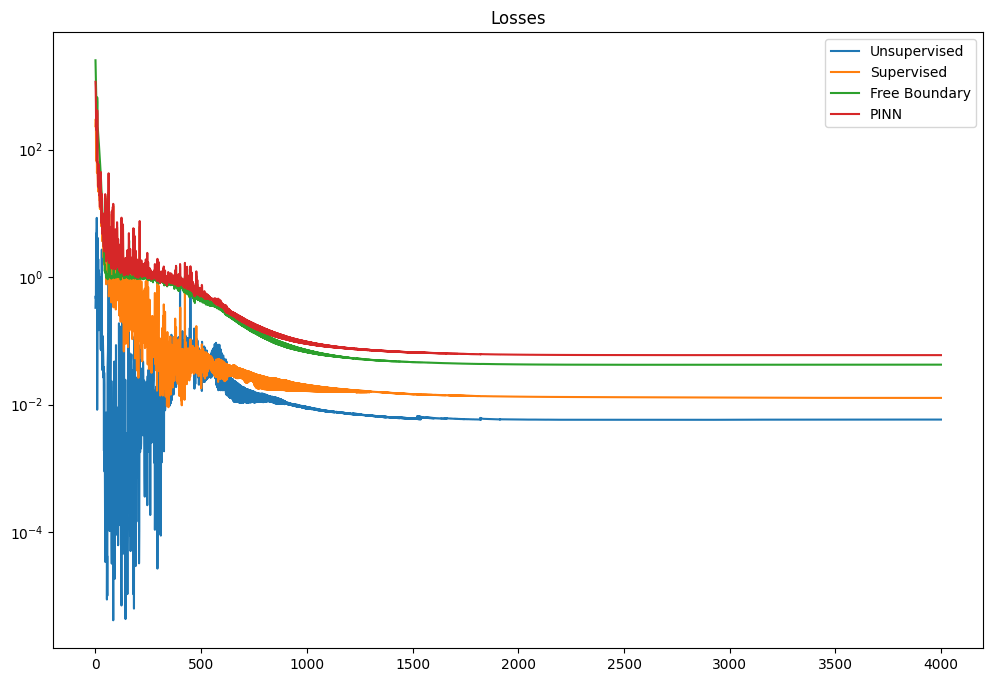

Time taken to train: 1378.818347


          Unsupervised   Initial        Dirichlet      Neumann        FB_Init        FB_Dir         FB_Neu         Free Boundary  Total          
          0.00591616     0.01348480     0.00000503     0.00000000     0.00116356     0.00389317     0.03697365     0.04203039     0.06027283     


In [9]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay as ex_d
my_lr = ex_d(1e-2, 500, 0.9, staircase=False)

params = {'sample_method':'sobol',
          'layers':[n_dim+1, 20, 20, 20, 20, 20, 20, 20, 20, 1],
          'activation':'tanh',
          'output_act':'linear', 'initializer':'glorot_normal',
          'fb_layers':[1, 100, 100, 100, n_dim], 'fb_activation':'tanh',
          'fb_output_act':'linear', 'fb_initializer':'glorot_normal',
          'lr':my_lr, 'optimizer':'rmsprop',
          'fb_lr':my_lr, 'fb_optimizer':'rmsprop', 'steps_fb_per_pde':20,
          'pde_weight':1, 'epochs':4000, 'verbose':50}

my_pinn = FreeBoundary_PINN(params, pde, pinn_conditions,
                            fb_conditions, lb, ub, N_f=30000, DTYPE=DTYPE)

START = time.time()
my_pinn.fit()
train_time = time.time() - START
my_pinn.plot_losses()

print(f"Time taken to train: {train_time:.6f}")

START = time.time()
values = my_pinn.plot_unsupervised_test(test_sampler, pinn_cond_test,
                                        fb_cond_test, output=True)
test_time = time.time() - START

In [10]:
data_to_predict = np.array([[36, 1.00]])
X = tf.convert_to_tensor(data_to_predict)

In [12]:
predictions = my_pinn.mdl.predict(X)
predictions

1/1 [==============================] - 0s 370ms/step


array([[4.016121]], dtype=float32)